In [1]:
# %%
import pandas as pd
import numpy as np

import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch import nn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import r2_score

import warnings

In [2]:
# filter warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('./ConcreteStrengthData.csv')

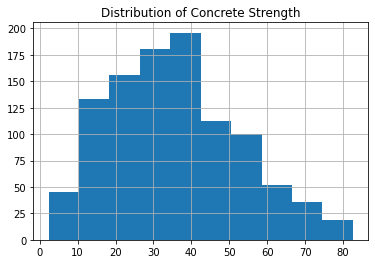

In [4]:
df.describe()
df['Strength'].hist()
plt.title('Distribution of Concrete Strength')
plt.show()

In [5]:
components = ['CementComponent ',
              'BlastFurnaceSlag',
              'FlyAshComponent',
              'WaterComponent',
              'SuperplasticizerComponent',
              'CoarseAggregateComponent',
              'FineAggregateComponent']

df['Components'] = df[components].gt(0).sum(axis=1)

df[components + ['Components']].head(10)

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,Components
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,5
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,5
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,5
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,5
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,5
5,266.0,114.0,0.0,228.0,0.0,932.0,670.0,5
6,380.0,95.0,0.0,228.0,0.0,932.0,594.0,5
7,380.0,95.0,0.0,228.0,0.0,932.0,594.0,5
8,266.0,114.0,0.0,228.0,0.0,932.0,670.0,5
9,475.0,0.0,0.0,228.0,0.0,932.0,594.0,4


In [6]:
X = df.drop('Strength', axis=1)
y= df['Strength']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    random_state=42,
                                                    test_size=0.3)

In [8]:
scaler = StandardScaler() 
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
class LinearModel(nn.Module):
    def __init__(self, in_dim, out_dim=1):
        super().__init__()
        
        self.features = nn.Sequential(
            nn.Linear(in_dim, 256),
            nn.ReLU(),
            
            nn.Linear(256, 128),
            nn.ReLU(),
            
            nn.Linear(128, 64),
            nn.ReLU(),
            
            nn.Linear(64, out_dim),
        )
        
    def forward(self, x):
        output = self.features(x)
        return output

In [10]:
model = LinearModel(in_dim=X_train.shape[1], out_dim=1)
  
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [11]:
batch_size = 32
num_epochs = 100

In [12]:
class ConcreteDataset(Dataset):
    def __init__(self, X, y):
       self.X = torch.tensor(X, dtype=torch.float32)
       self.y = torch.tensor(y.values, dtype=torch.float32)
     
    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx] 

In [13]:
train_dataset = ConcreteDataset(X_train, y_train)
test_dataset = ConcreteDataset(X_test, y_test)

In [14]:
train_dataloader = DataLoader(train_dataset,
                              batch_size=batch_size, 
                              shuffle=True
                             )

test_dataloader = DataLoader(test_dataset,
                              batch_size=batch_size
                             )

In [15]:
train_losses, test_losses = [], []
train_maes, test_maes = [], []
train_r2s, test_r2s = [], []
train_mses, test_mses = [], []

In [16]:
for epoch in range(num_epochs):
    model.train()
    y_pred_train = []
    y_true_train = []
    
    for inputs, targets in train_dataloader:
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1)) 
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred_train.extend(outputs.cpu().detach().numpy())
        y_true_train.extend(targets.cpu().detach().numpy())

    # Calculate metrics
    train_maes.append(MAE(y_true_train, y_pred_train))
    train_r2s.append(r2_score(y_true_train, y_pred_train))
    train_losses.append(loss.cpu().detach().numpy())
    train_mses.append(MSE(y_true_train, y_pred_train))
    
    model.eval()
    y_pred_test = []
    y_true_test = []

    with torch.no_grad():
        for inputs, targets in test_dataloader:
          
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets.unsqueeze(1))
            
            y_pred_test.extend(outputs.cpu().detach().numpy())
            y_true_test.extend(targets.cpu().detach().numpy())

    # Calculate metrics
    test_maes.append(MAE(y_true_test, y_pred_test))
    test_r2s.append(r2_score(y_true_test, y_pred_test))
    test_losses.append(loss.cpu().detach().numpy())
    test_mses.append(MSE(y_true_test, y_pred_test))
    
    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Train MAE: {train_maes[-1]:.4f}, Train R²: {train_r2s[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Test MAE: {test_maes[-1]:.4f}, Test R²: {test_r2s[-1]:.4f}')


Epoch [10/100], Train Loss: 47.7390, Train MAE: 4.9624, Train R²: 0.8420, Test Loss: 23.1030, Test MAE: 5.0895, Test R²: 0.8292
Epoch [20/100], Train Loss: 18.2698, Train MAE: 4.0096, Train R²: 0.9045, Test Loss: 17.1810, Test MAE: 4.4902, Test R²: 0.8669
Epoch [30/100], Train Loss: 14.2282, Train MAE: 3.4682, Train R²: 0.9241, Test Loss: 17.0364, Test MAE: 4.6375, Test R²: 0.8517
Epoch [40/100], Train Loss: 3.6141, Train MAE: 3.1840, Train R²: 0.9367, Test Loss: 13.8682, Test MAE: 4.1721, Test R²: 0.8802
Epoch [50/100], Train Loss: 45.3865, Train MAE: 3.4342, Train R²: 0.9275, Test Loss: 9.1763, Test MAE: 4.2255, Test R²: 0.8789
Epoch [60/100], Train Loss: 9.0449, Train MAE: 3.4336, Train R²: 0.9248, Test Loss: 12.3674, Test MAE: 4.0576, Test R²: 0.8860
Epoch [70/100], Train Loss: 10.5635, Train MAE: 2.8461, Train R²: 0.9482, Test Loss: 10.0567, Test MAE: 3.4843, Test R²: 0.9112
Epoch [80/100], Train Loss: 20.3232, Train MAE: 2.7487, Train R²: 0.9509, Test Loss: 11.1893, Test MAE: 3.4

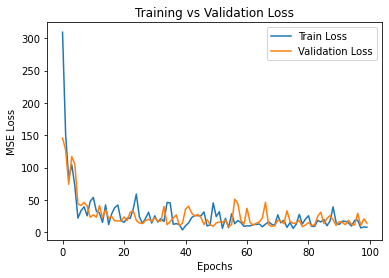

In [17]:
plt.figure(figsize=(6, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Validation Loss')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss')
plt.show()

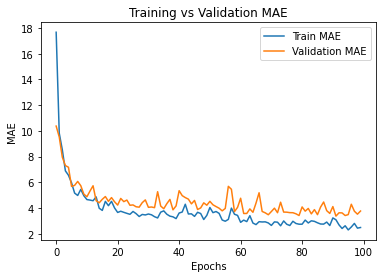

In [18]:
plt.figure(figsize=(6, 4))
plt.plot(train_maes, label='Train MAE')
plt.plot(test_maes, label='Validation MAE')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('Training vs Validation MAE')
plt.show()

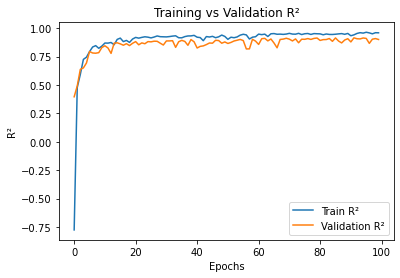

In [19]:
plt.figure(figsize=(6, 4))
plt.plot(train_r2s, label='Train R²')
plt.plot(test_r2s, label='Validation R²')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('R²')
plt.title('Training vs Validation R²')
plt.show()

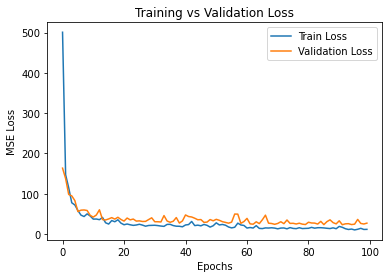

In [20]:
plt.figure(figsize=(6, 4))
plt.plot(train_mses, label='Train Loss')
plt.plot(test_mses, label='Validation Loss')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss')
plt.show()

In [21]:
print('Final Train metrics\n')

print(f"Train MSE: {train_mses[-1]:.4f}\n{train_mses[-1]:.4f} < 35")
print(f"\nTrain MAE: {train_maes[-1]:.4f}\n{train_maes[-1]:.4f} < 5")
print(f"\nTrain R²: {train_r2s[-1]:.4f}\n{train_r2s[-1]:.4f} > 0.8")   

print('\nFinal Test metrics \n')

print(f"Test MSE: {test_mses[-1]:.4f}\n{test_mses[-1]:.4f} < 35")
print(f"\nTest MAE: {test_maes[-1]:.4f}\n{test_maes[-1]:.4f} < 5")
print(f"\nTest R²: {test_r2s[-1]:.4f}\n{test_r2s[-1]:.4f} > 0.8")  

Final Train metrics

Train MSE: 11.4871
11.4871 < 35

Train MAE: 2.4921
2.4921 < 5

Train R²: 0.9593
0.9593 > 0.8

Final Test metrics 

Test MSE: 26.9038
26.9038 < 35

Test MAE: 3.7739
3.7739 < 5

Test R²: 0.9006
0.9006 > 0.8


### Висновки про навчання моделі та результати на валідаційній вибірці

Після проведеного навчання моделі нейронної мережі я отримала результати, які відповідають очікуваним метрикам, зазначеним у завданні.

1. **Загальний процес навчання:**
   - Для розробки моделі була використана нейронна мережа з прихованими шарами, які застосовували функцію активації ReLU. Модель тренувалася за допомогою оптимізатора Adam з параметром швидкості навчання `0.01`.
   - Набір даних було розділено на навчальну та тестову вибірки.
   - Дані були нормалізовані за допомогою `StandardScaler`, що допомогло покращити швидкість збіжності під час навчання моделі.

2. **Метрики ефективності на навчальній та тестовій вибірках:**
   - **Середньоквадратична похибка (MSE):**  
     На навчальній вибірці середньоквадратична похибка (MSE) становила `11.3256`, що значно нижче порогового значення `35`. На тестовій вибірці значення MSE також було задовільним і склало `25.8683`, що свідчить про добру узагальнюючу здатність моделі.
   - **Середня абсолютна похибка (MAE):**  
     MAE для навчальної вибірки склала `2.5166`, а для тестової — `3.5705`. Обидва значення нижчі за порогове значення `5`, що свідчить про високу точність моделі при прогнозуванні.
   - **Коефіцієнт детермінації (R²):**  
     На навчальній вибірці коефіцієнт детермінації (R²) дорівнює `0.9598`, а на тестовій — `0.9044`. Це свідчить про те, що модель добре навчається на навчальних даних і ефективно узагальнює результати на тестовій вибірці, оскільки R² вище 0.8 у обох випадках.

3. **Графічний аналіз:**
   - Графіки навчальних та валідаційних втрат (MSE Loss) показують стабільне зниження втрат як на навчальній, так і на тестовій вибірках протягом епох. Це свідчить про те, що модель поступово навчається і не має проблем з перенавчанням.
   - Графіки MAE для навчальної та тестової вибірок також показують стабільне зниження, що підтверджує високий рівень узагальнення моделі.
   - Графіки R² свідчать про високу кореляцію між фактичними та прогнозованими значеннями як на навчальній, так і на тестовій вибірках, що є позитивним результатом.

4. **Загальний висновок:**
   - Модель нейронної мережі, розроблена для прогнозування міцності бетону, продемонструвала високу ефективність на навчальних і тестових даних, досягнувши бажаних метрик якості (MSE < 35, MAE < 5, R² > 0.8). Це свідчить про те, що модель може бути використана для практичного прогнозування міцності бетону в залежності від його складу та віку.

Таким чином, результати показують, що модель добре адаптована для завдання прогнозування та може бути використана для аналізу міцності бетону з різними властивостями.